[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv8 Classification on a Custom Dataset

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/wuZtUMEiKWY)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

Ultralytics YOLOv8 is the latest version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics. The YOLOv8 model is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and image segmentation tasks. It can be trained on large datasets and is capable of running on a variety of hardware platforms, from CPUs to GPUs.

## ⚠️ Disclaimer

As of 18.01.2023, YOLOv8 Classification seems a tad underdeveloped. It is possible to train models, but their usability is questionable. Known problems include:
- The model pre-trained on the Imagenet dataset operates on the id of classes not their names. Only after custom post-processing can you find out how the image was classified.
- No detailed training data available. At this point, it is almost standard to save information such as confusion matrix or graphs of key metrics after a training session is completed. YOLOv8 offers this feature but for the moment only for Object Detection and Instance Segmentation.
- In the case of the CLI, there is no saving of the prediction in text form. They are annotated on the image, which in practice makes it impossible to build any application using them.
- With SDK, a difficult-to-interpret matrix is returned instead of a vector of probabilities. Only after custom post-processing can you find out how the image was classified.

## Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on how to train YOLOv8 Classification, concurrently.

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install YOLOv8
- CLI Basics
- Inference with Pre-trained COCO Model
- Roboflow Universe
- Preparing a custom dataset
- Custom Training
- Validate Custom Model
- Inference with Custom Model

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Jun 11 13:27:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. We strive to make our YOLOv8 notebooks work with the latest version of the library. Last tests took place on **18.01.2023** with version **YOLOv8.0.9**.

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

YOLOv8 can be installed in two ways - from the source and via pip. This is because it is the first iteration of YOLO to have an official package.

In [3]:
# Pip install method (recommended)
!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.0/78.2 GB disk)


In [4]:
from ultralytics import YOLO

from IPython.display import display, Image

`yolo mode=predict` runs YOLOv8 inference on a variety of sources, downloading models automatically from the latest YOLOv8 release, and saving results to `runs/predict`.

In [5]:
!mkdir {HOME}/dataset
%cd {HOME}/dataset

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ztSFTV10PBE8i7KVhueC")
project = rf.workspace("1sep208panisara-triamrangsee").project("gingivitis-dyrjr")
version = project.version(1)
dataset = version.download("folder")



/content/dataset
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 9.5 MB/s eta 0:00:00
Reason for being yanked: deprecated, use 4.8.0.76
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.10.0.82
    Uninstalling opencv-python-headless-4.10.0.82:
      Successfully uninstalled opencv-python-headless-4.10.0.82
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to gingivitis-1 in folder:: 100%|██████████| 576/576 [00:00<00:00, 6886.75it/s]


## Custom Training

In [10]:
%cd {HOME}

!yolo task=classify mode=train model=yolov8n-cls.pt data={dataset.location} epochs=30 imgsz=128

/content
New https://pypi.org/project/ultralytics/8.2.31 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/dataset/gingivitis-1, epochs=30, patience=50, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, 

In [7]:
!ls -la {HOME}/runs/classify/train/

total 1104
drwxr-xr-x 3 root root   4096 Jun 11 13:32 .
drwxr-xr-x 3 root root   4096 Jun 11 13:31 ..
-rw-r--r-- 1 root root   1416 Jun 11 13:31 args.yaml
-rw-r--r-- 1 root root  99416 Jun 11 13:32 confusion_matrix_normalized.png
-rw-r--r-- 1 root root  93120 Jun 11 13:32 confusion_matrix.png
-rw-r--r-- 1 root root 167226 Jun 11 13:32 events.out.tfevents.1718112672.f2cc1a0da76c.3785.0
-rw-r--r-- 1 root root   4032 Jun 11 13:32 results.csv
-rw-r--r-- 1 root root 126115 Jun 11 13:32 results.png
-rw-r--r-- 1 root root  56562 Jun 11 13:31 train_batch0.jpg
-rw-r--r-- 1 root root  58798 Jun 11 13:31 train_batch1.jpg
-rw-r--r-- 1 root root  54742 Jun 11 13:31 train_batch250.jpg
-rw-r--r-- 1 root root  60955 Jun 11 13:31 train_batch251.jpg
-rw-r--r-- 1 root root  59175 Jun 11 13:31 train_batch252.jpg
-rw-r--r-- 1 root root  62315 Jun 11 13:31 train_batch2.jpg
-rw-r--r-- 1 root root  60598 Jun 11 13:32 val_batch0_labels.jpg
-rw-r--r-- 1 root root  60598 Jun 11 13:32 val_batch0_pred.jpg
-rw-r--r

In [8]:
!cat {HOME}/runs/classify/train2/results.csv | head -21

cat: /content/runs/classify/train2/results.csv: No such file or directory


## Validate Custom Model

In [ ]:
%cd {HOME}

!yolo task=classify mode=val model={HOME}/runs/classify/train2/weights/best.pt data={dataset.location}

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1437442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/dataset/ORALC-1/train... found 472 images in 2 classes ✅ 
val: /content/dataset/ORALC-1/val... found 131 images in 2 classes ✅ 
test: /content/dataset/ORALC-1/test... found 72 images in 2 classes ✅ 
val: Scanning /content/dataset/ORALC-1/val... 131 images, 0 corrupt: 100% 131/131 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100% 9/9 [00:01<00:00,  6.77it/s]
                   all      0.985          1
Speed: 0.5ms preprocess, 5.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [9]:
from ultralytics import YOLO
import torch
import cv2
import pandas as pd
# Create a new detection model and transfer the weights from a classification model
detect_model = YOLO('yolov8n.yaml').load('best.pt')


image = cv2.imread("8.jpg")
results = detect_model(image)
print("Results:", results)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

FileNotFoundError: [Errno 2] No such file or directory: 'best.pt'

## Inference with Custom Model

In [ ]:
%cd {HOME}
!yolo task=classify mode=predict model={HOME}/runs/classify/train4/weights/best.pt conf=0.25 source=/content/dataset/ORALC-1/test/Gingivitis

/content
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 420, in entrypoint
    model = YOLO(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 97, in __init__
    self._load(model, task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 149, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 628, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 567, in torch_safe_load
    return torch.load(file, map_location='cpu'), file  # load
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 997, in load
    with _open_file_like(f, 'rb') 

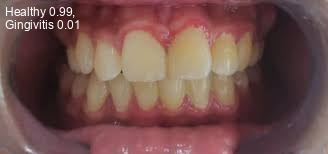

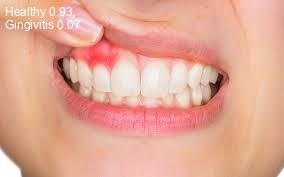

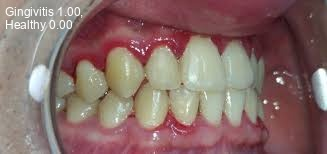

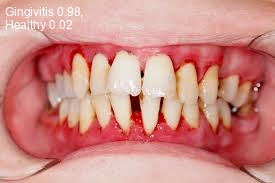

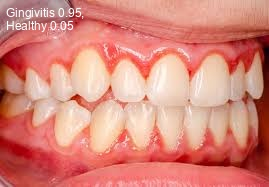

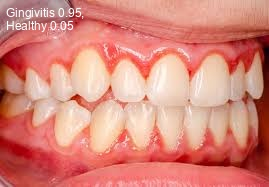

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/classify/predict4/*.jpg')[:93]:
      display(Image(filename=image_path, width=600))
      print("\n")